### Import libries

In [1]:
import numpy as np
from collections import Counter
from sklearn import datasets
from sklearn.model_selection import train_test_split

### Create Node class

In [2]:
class Node:
    """
    A class representing a node in the decision tree.
    
    If this is a leaf node, it will store the predicted `value`.
    If this is a decision node, it will store `feature_idx` (the feature to split on),
    `threshold` (the threshold to split at), and the `left` and `right` children.
    """
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
    
    def is_leaf_node(self):
        return self.value is not None

### Create Decision Tree class

In [3]:
class DecisionTreeClassifier:
    """
    The Decision Tree class.
    
    Hyperparameters:
        min_samples_split (int): The minimum number of samples required at a node
                                 to consider splitting further.
        max_depth (int): The maximum depth of the tree.
        n_features (int): The number of features randomly sampled at each node.
    """
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None)        :
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.root = None
    

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1], self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        """
        The main recursive function to build the tree.
        """

        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # --- 1. Check stopping criteria ---
        # Criteria 1: Maximum depth reached
        # Criteria 2: Too few samples to split
        # Criteria 3: Node is "pure" (only one class left)
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)
        
        # --- 2. Find the best split
        # Randomly select feature indices to iterate over (like Random Forest)
        # This makes the tree more robust if there are many features
        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)
        best_feature, best_threshold, best_gain = self._best_split(X, y, feat_idxs)
        if best_gain == 0:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        # --- 3. Create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feature], best_threshold)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)

        return Node(best_feature, best_threshold, left, right)
    
    def _best_split(self, X, y, feat_idxs):
        best_gain = 0
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for threshold in thresholds:
                # calculate the information gain
                gain = self._information_gain(y, X_column, threshold)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = threshold
        return split_idx, split_threshold, best_gain
    
    def _information_gain(self, y, X_column, threshold):
        """
        Calculate Information Gain.
        Gain(S, A) = Entropy(S) - Weighted_Average_Entropy(Children)
        """
        # parent entropy
        parent_entropy = self._entropy(y)

        # crate children
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        
        # calculate the weight avg. entropy of children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        # calculate the IG
        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_threshold):
        """Helper function to split a data column by a threshold."""
        left_idxs = np.argwhere(X_column <= split_threshold).flatten()
        right_idxs = np.argwhere(X_column > split_threshold).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        """
        Calculate Entropy (impurity).
        H(X) = - sum( p(x) * log2(p(x)) )
        """
        hist = np.bincount(y)
        ps = hist / len(y)
        entropy = -np.sum([p * np.log2(p) for p in ps if p > 0])
        return entropy
    
    def _most_common_label(self, y):
        """Find the most common label in a leaf node."""
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        """
        Recursive function to traverse the tree for a single sample (x)
        to find the prediction.
        """
        if node.is_leaf_node():
            return node.value
        
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

### Evaluate

In [4]:
data = datasets.load_breast_cancer()
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / len(y_test)

acc = accuracy(y_test, predictions)

print("Accuracy Decision Tree from scratch", acc)  

Accuracy Decision Tree from scratch 0.9385964912280702


In [5]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion="entropy")
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

acc = accuracy(y_test, predictions)

print("Accuracy Decision Tree sklearn", acc)

Accuracy Decision Tree sklearn 0.8947368421052632


In [6]:
feature_names = data.feature_names
feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

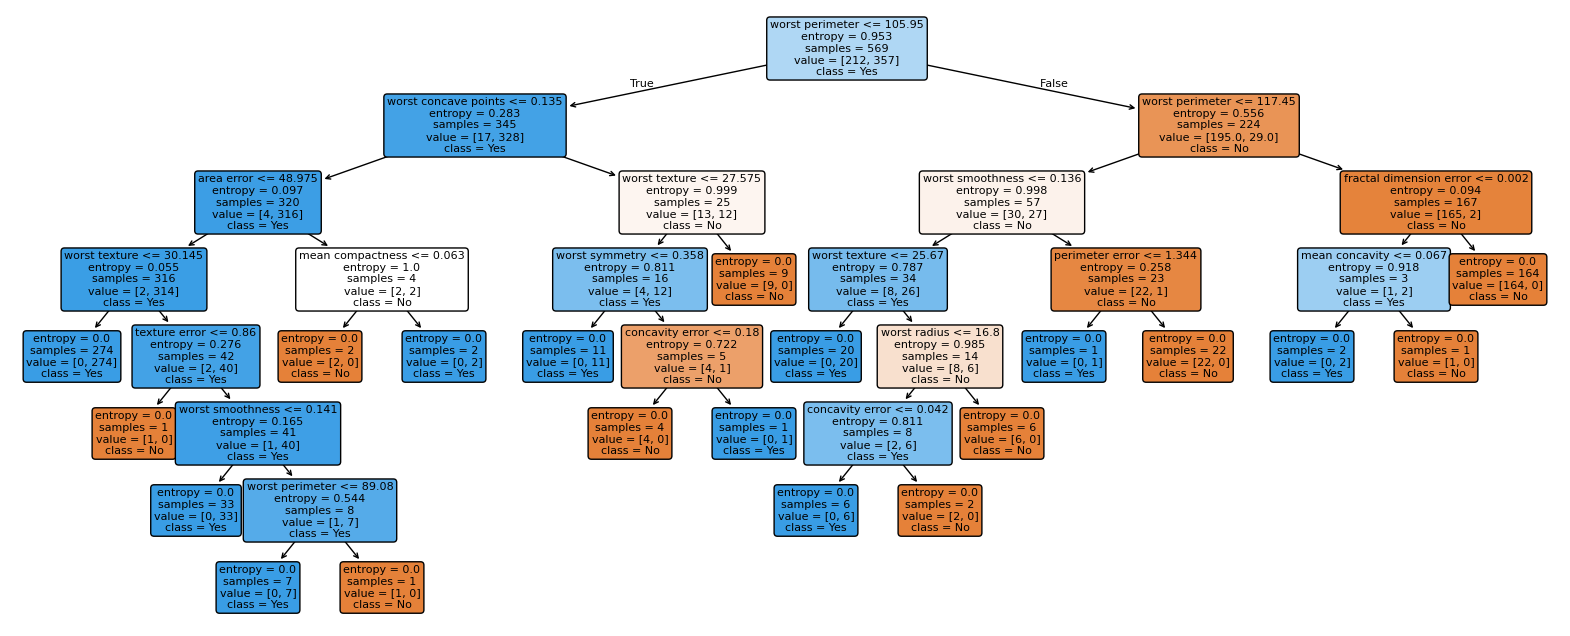

In [7]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

clf.fit(X, y)
plt.figure(figsize=(20, 8))

plot_tree(
    clf,
    feature_names=feature_names,
    class_names=["No", "Yes"],
    filled=True,
    rounded=True,
    fontsize=8
);